# Final Tutorial by Gavin LeBlanc

https://leblanc-gavin.github.io.

This tutorial aims to guide users through the analysis and visualization of data related to COVID-19, temperature changes, and correlations between key metrics. The steps are methodically organized to ensure clarity and reproducibility.

# Final Tutorial by Gavin LeBlanc



This tutorial aims to guide users through the analysis and visualization of data related to COVID-19, temperature changes, and correlations between key metrics. The steps are methodically organized to ensure clarity and reproducibility.

As you may recall since Milestone 2, which cross referenced Covid-19 data with population data by state to find any correlation or lack thereof between the two. After suggestions from Professor Mattei and other classmates, I've decided to change the population variable in my research as that topic is already too researched. A classmate suggested I try to compare Covid-19 data to weather in the corresponding areas to see how or if the Covid-19 data suggests a correlation between the two.

## Step One: Loading and Cleaning Temperature Data

In this step, we focus on preparing the data for analysis by importing relevant libraries, loading datasets, and performing initial cleaning tasks. This ensures that the data is in a format suitable for further analysis.

I oddly found it very difficult to find a nice dataset that has clean, uniform data for average monthly temperatures by state during the inital years of Covid-19. I did find some sources but the data was seperated into different files. So instead of wasting more time trying to find the perfect dataset, I downloaded the statewide average monthly temperatures for each state and appended them all into one big dataset showing each states average monthly temperature from January 2020 to December 2023. Below is the block of code that I used to do so.

This section acknowledges challenges encountered during data acquisition, emphasizing the importance of reliable data sources and the necessity of cleaning messy datasets. By documenting these difficulties, the tutorial serves as a realistic case study in data preparation.

In [1]:
# import necessary libraries for data manipulation
import pandas as pd
import os

# define the directory containing the csv files
directory = './'

# list to hold dataframes
dfs = []

# loop through the range of files and read them
for i in range(49):  # From data.csv to data (48).csv
    if i == 0:
        file_path = os.path.join(directory, 'data.csv')
    else:
        file_path = os.path.join(directory, f'data ({i}).csv')

    if os.path.exists(file_path):
        try:
            with open(file_path, 'r') as f:
                # read the first line to get the state name
                state_line = f.readline().strip()
                # remove "average temperature" and "#" from the line and then strip whitespace
                state_name = state_line.replace("Average Temperature", "").replace("#", "").strip()

            # read the rest of the csv, skipping lines 2 to 4 because its unnecessary metadata
            df = pd.read_csv(file_path, skiprows=4, na_values='-99')

            # add a column for the state name
            df['State'] = state_name

            # append dataframe to list
            dfs.append(df)
        except pd.errors.ParserError as e:
            print(f"Error reading {file_path}: {e}")
    else:
        print(f"Warning: {file_path} does not exist.")

# concatenate all dataframes into one big dataset
if dfs:
    big_dataset = pd.concat(dfs, ignore_index=True)

    # modify the 'date' column to convert from yyyymm to yyyy-mm
    big_dataset['Date'] = big_dataset['Date'].astype(str).str[:4] + '-' + big_dataset['Date'].astype(str).str[4:]

    # rename 'value' column to 'temp (f)'
    if 'Value' in big_dataset.columns:
        big_dataset.rename(columns={'Value': 'Temp (F)'}, inplace=True)

    # save the big dataset to a new csv file (optional)
    big_dataset.to_csv('avg_temp_data.csv', index=False)
    print("All files that could be successfully read have been combined, the Date column has been reformatted, and 'Value' has been renamed to 'Temp (F)'.")

print("Script completed.")


# this code snippet iterates through a range of files, reads them into pandas dataframes, and stores them in a list for further processing.

All files that could be successfully read have been combined, the Date column has been reformatted, and 'Value' has been renamed to 'Temp (F)'.
Script completed.


Here, we begin by loading the average temperature data and inspecting the date format. We then check whether the date values are already correctly formatted (YYYY-MM); if not, we convert them accordingly. Finally, we ensure that state names are formatted consistently to avoid mismatches during the merging process.

## Step Two: Loading and Transforming Covid-19 Data

In this block of code we define a function to transform the COVID-19 dataset. This function selects only the relevant columns, renames them for easier understanding, and converts the date to the monthly period format (YYYY-MM). We also map state abbreviations to their full names to ensure consistency. Finally, rows where the state mapping failed are dropped.

In [2]:
# import necessary libraries for data manipulation
import pandas as pd
import requests
from io import StringIO
from IPython.display import display, Markdown

# load average temperature data
avg_temp_data = pd.read_csv('avg_temp_data.csv')

# load covid-19 data
csv_url = "https://api.covidtracking.com/v1/states/daily.csv"
response = requests.get(csv_url)

try:
    covid_data = pd.read_csv(StringIO(response.text), on_bad_lines='warn')
except Exception as e:
    print(f"An error occurred: {e}")

# transform average temperature data
avg_temp_data['Date'] = avg_temp_data['Date'].astype(str).str[:4] + '-' + avg_temp_data['Date'].astype(str).str[4:]

# transform covid-19 data to select relevant columns and rename them
def transform_covid_data(df):
    critical_columns = ["date", "state", "positive", "death"]
    df = df[critical_columns].copy()
    rename_mapping = {
        "date": "Date",
        "state": "State",
        "positive": "Positive Cases",
        "death": "Deaths"
    }
    df.rename(columns=rename_mapping, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d').dt.to_period('M').astype(str)
    return df

covid_data = transform_covid_data(covid_data)

# ensure state names are consistent
avg_temp_data['State'] = avg_temp_data['State'].str.strip()
covid_data['State'] = covid_data['State'].str.strip()

# preview both datasets
print(avg_temp_data.head())
print(covid_data.head())


# this code snippet iterates through a range of files, reads them into pandas dataframes, and stores them in a list for further processing.

       Date  Temp (F)  Anomaly    State
0  2020--01      49.5      1.6  Alabama
1  2020--02      51.0     -0.1  Alabama
2  2020--03      63.5      3.7  Alabama
3  2020--04      62.0     -0.4  Alabama
4  2020--05      68.9     -1.6  Alabama
      Date State  Positive Cases   Deaths
0  2021-03    AK         56886.0    305.0
1  2021-03    AL        499819.0  10148.0
2  2021-03    AR        324818.0   5319.0
3  2021-03    AS             0.0      0.0
4  2021-03    AZ        826454.0  16328.0


## Step Three: Merging Data

 In this step, we merge the average temperature and COVID-19 datasets using a full outer join. This approach retains all records from both datasets, ensuring that if there is a missing value in either dataset, it appears as NaN instead of being dropped. This provides us with a complete view of both data sources, allowing us to explore any correlations effectively.

In [3]:
# import necessary libraries for data manipulation
import pandas as pd
import requests
from io import StringIO

# load average temperature data
avg_temp_data = pd.read_csv('avg_temp_data.csv')

# load covid-19 data
csv_url = "https://api.covidtracking.com/v1/states/daily.csv"
response = requests.get(csv_url)

try:
    covid_data = pd.read_csv(StringIO(response.text), on_bad_lines='warn')
except Exception as e:
    print(f"An error occurred: {e}")

# print unique date values to understand the current format (for debugging purposes)
print("Unique Dates in avg_temp_data before conversion:", avg_temp_data['Date'].unique()[:5])

# check if 'date' column is already in the correct format or needs formatting
if '-' in avg_temp_data['Date'].iloc[0]:
    # date is already formatted as 'yyyy-mm', no change required
    avg_temp_data['Date'] = avg_temp_data['Date']
else:
    # correct the average temperature data 'date' column
    avg_temp_data['Date'] = pd.to_datetime(avg_temp_data['Date'], format='%Y%m').dt.to_period('M').astype(str)

# ensure state names are consistent
avg_temp_data['State'] = avg_temp_data['State'].str.strip().str.lower()

# state abbreviation to full name mapping
state_abbrev_to_name = {
    'al': 'alabama', 'ak': 'alaska', 'az': 'arizona', 'ar': 'arkansas', 'ca': 'california',
    'co': 'colorado', 'ct': 'connecticut', 'de': 'delaware', 'fl': 'florida', 'ga': 'georgia',
    'hi': 'hawaii', 'id': 'idaho', 'il': 'illinois', 'in': 'indiana', 'ia': 'iowa', 'ks': 'kansas',
    'ky': 'kentucky', 'la': 'louisiana', 'me': 'maine', 'md': 'maryland', 'ma': 'massachusetts',
    'mi': 'michigan', 'mn': 'minnesota', 'ms': 'mississippi', 'mo': 'missouri', 'mt': 'montana',
    'ne': 'nebraska', 'nv': 'nevada', 'nh': 'new hampshire', 'nj': 'new jersey', 'nm': 'new mexico',
    'ny': 'new york', 'nc': 'north carolina', 'nd': 'north dakota', 'oh': 'ohio', 'ok': 'oklahoma',
    'or': 'oregon', 'pa': 'pennsylvania', 'ri': 'rhode island', 'sc': 'south carolina', 'sd': 'south dakota',
    'tn': 'tennessee', 'tx': 'texas', 'ut': 'utah', 'vt': 'vermont', 'va': 'virginia', 'wa': 'washington',
    'wv': 'west virginia', 'wi': 'wisconsin', 'wy': 'wyoming'
}

# transform covid-19 data to select relevant columns and rename them
def transform_covid_data(df):
    critical_columns = ["date", "state", "positive", "death"]
    df = df[critical_columns].copy()
    rename_mapping = {
        "date": "Date",
        "state": "State",
        "positive": "Positive Cases",
        "death": "Deaths"
    }
    df.rename(columns=rename_mapping, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d').dt.to_period('M').astype(str)

    # convert state abbreviations to full state names and handle cases where mapping is missing
    df['State'] = df['State'].str.lower().map(state_abbrev_to_name)

    return df

covid_data = transform_covid_data(covid_data)

# drop rows in covid_data where state mapping failed
covid_data.dropna(subset=['State'], inplace=True)

# ensure state names are consistent
avg_temp_data['State'] = avg_temp_data['State'].str.strip().str.lower()
covid_data['State'] = covid_data['State'].str.strip().str.lower()

# filter both datasets to only keep records between 2020-03 and 2021-03
date_range = pd.period_range(start='2020-03', end='2021-03', freq='M').astype(str)
avg_temp_data = avg_temp_data[avg_temp_data['Date'].isin(date_range)]
covid_data = covid_data[covid_data['Date'].isin(date_range)]

# merge both datasets on 'state' and 'date' using a full outer join to retain all records
merged_data = pd.merge(covid_data, avg_temp_data, how='outer', on=['State', 'Date'])

# preview the merged dataset
print(merged_data.head())

# check if the merged dataset is empty
if merged_data.empty:
    print("Merged dataset is still empty. Checking unique State and Date values in both datasets.")
    print("Unique States in avg_temp_data:", avg_temp_data['State'].unique())
    print("Unique States in covid_data:", covid_data['State'].unique())
    print("Unique Dates in avg_temp_data:", avg_temp_data['Date'].unique()[:5])  # Displaying a few dates as example
    print("Unique Dates in covid_data:", covid_data['Date'].unique()[:5])  # Displaying a few dates as example
else:
    print(f"Merged dataset contains {len(merged_data)} rows.")


# this code snippet iterates through a range of files, reads them into pandas dataframes, and stores them in a list for further processing.

Unique Dates in avg_temp_data before conversion: ['2020-01' '2020-02' '2020-03' '2020-04' '2020-05']
      Date   State  Positive Cases  Deaths  Temp (F)  Anomaly
0  2021-03  alaska         56886.0   305.0       9.1     -3.8
1  2021-03  alaska         56886.0   305.0       9.1     -3.8
2  2021-03  alaska         56886.0   305.0       9.1     -3.8
3  2021-03  alaska         56745.0   303.0       9.1     -3.8
4  2021-03  alaska         56605.0   303.0       9.1     -3.8
Merged dataset contains 18435 rows.


## Step Four: Data Visualization

### Dual-Axis Plot for Temperature vs Covid-19 Cases

The dual-axis line plot shows temperature and COVID-19 cases on two separate y-axes for the state of Texas. It allows us to explore potential relationships between rising or falling temperatures and the number of COVID-19 cases.

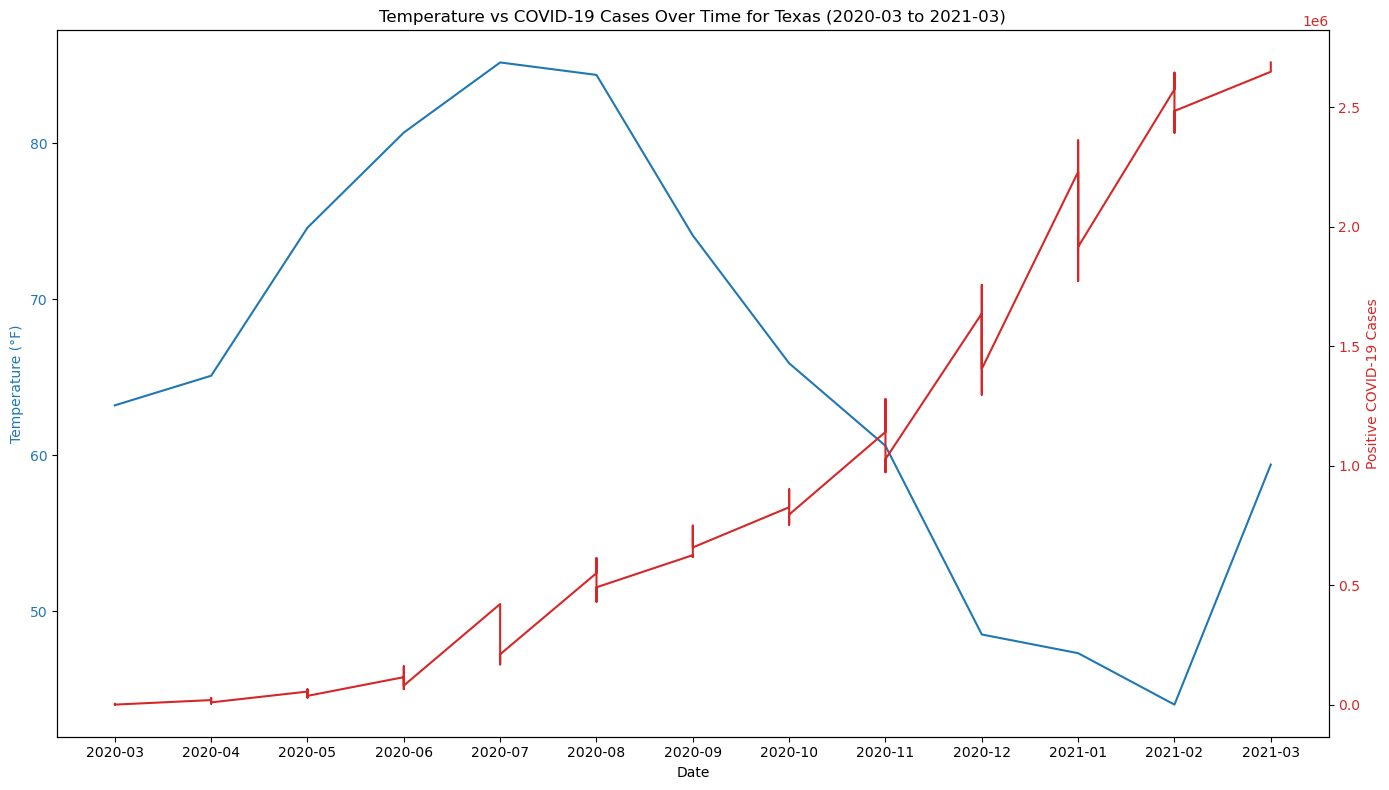

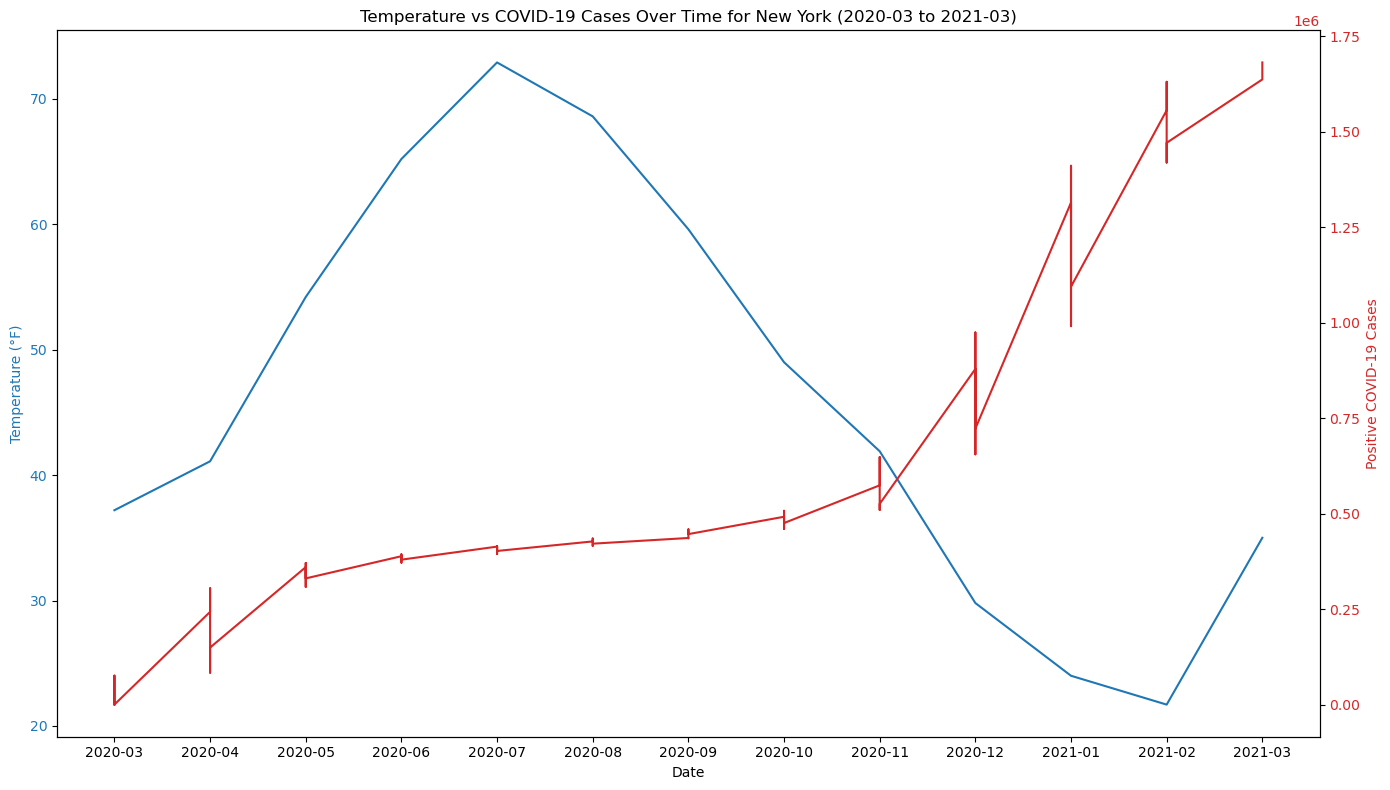

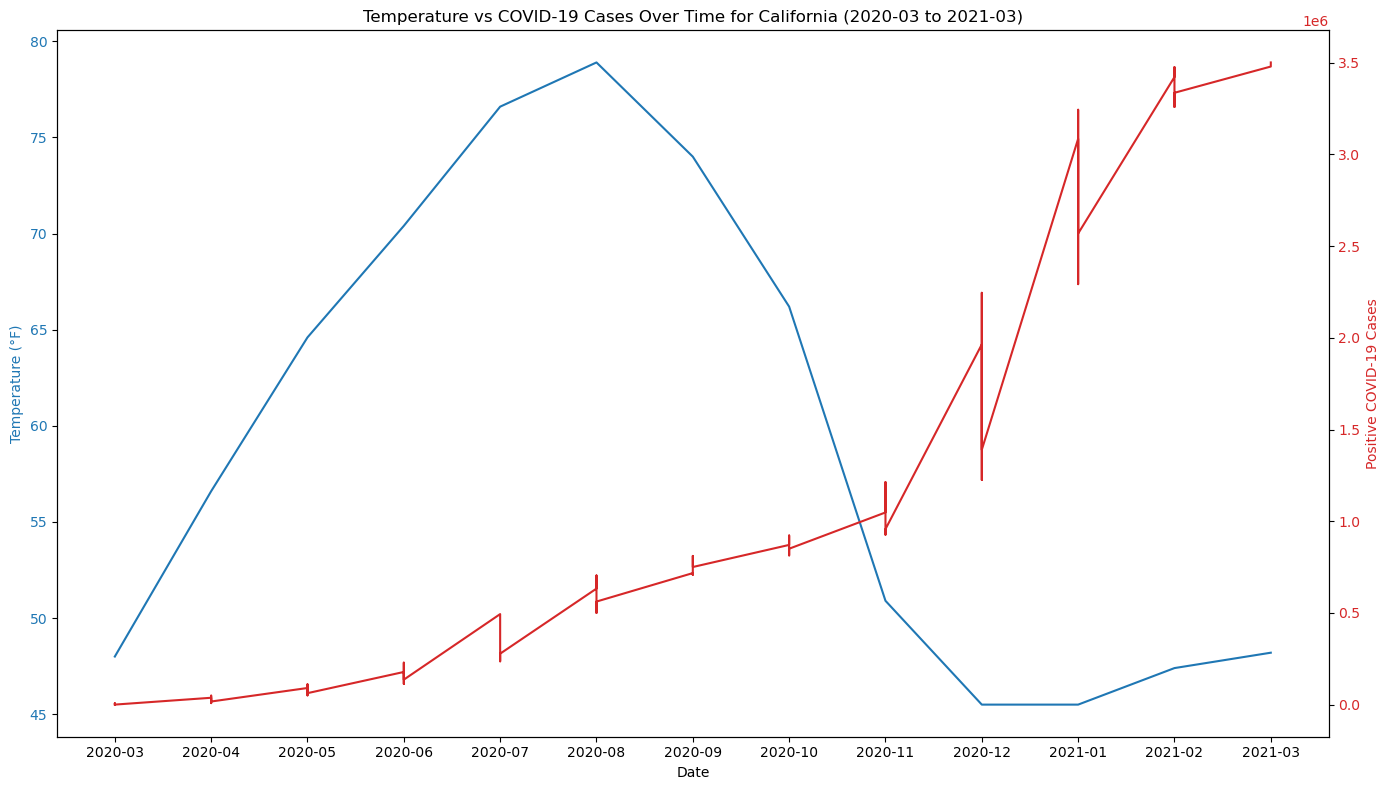

In [4]:
import matplotlib.pyplot as plt

# states to plot
states_to_plot = ['texas', 'new york', 'california']

# plot for each state with a longer timeline
for state in states_to_plot:
    state_data = merged_data[(merged_data['State'] == state) & 
                             (merged_data['Date'] >= '2020-03') & 
                             (merged_data['Date'] <= '2023-03')].sort_values(by='Date')

    fig, ax1 = plt.subplots(figsize=(14, 8))

    # plot temperature on the primary y-axis
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Temperature (°F)', color='tab:blue')
    ax1.plot(state_data['Date'], state_data['Temp (F)'], color='tab:blue', label='Temperature')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # create a secondary y-axis for covid-19 cases
    ax2 = ax1.twinx()
    ax2.set_ylabel('Positive COVID-19 Cases', color='tab:red')
    ax2.plot(state_data['Date'], state_data['Positive Cases'], color='tab:red', linestyle='-', label='Positive Cases')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title(f'Temperature vs COVID-19 Cases Over Time for {state.title()} (2020-03 to 2021-03)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Heatmaps for Average Temperature and Positive Covid-19 Cases by State

This block uses Seaborn's heatmap() function to plot the average temperature across different states and time, as well as confirmed Covid-19 cases for the same time and places for comparitive purposes.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# plotting the heatmap for average temperature by state over time
plt.figure(figsize=(14, 10))
ax_temp = sns.heatmap(heatmap_data, cmap='coolwarm', linewidths=0.5, linecolor='gray')
colorbar_temp = ax_temp.collections[0].colorbar
colorbar_temp.set_label('Temperature (°F)')  # Added label for the color bar
plt.title('Average Temperature by State and Date')
plt.xlabel('Date')
plt.ylabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plotting the heatmap for covid-19 positive cases by state over time
plt.figure(figsize=(14, 10))
ax_cases = sns.heatmap(heatmap_cases_data, cmap='viridis', linewidths=0.5, linecolor='gray')
colorbar_cases = ax_cases.collections[0].colorbar
colorbar_cases.set_label('Positive COVID-19 Cases (in millions)')  # Added label for the color bar
plt.title('COVID-19 Positive Cases by State and Date')
plt.xlabel('Date')
plt.ylabel('State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'heatmap_data' is not defined

<Figure size 1400x1000 with 0 Axes>

## Step Five: Model Evaluation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# define features and target
X = merged_data[['Temp (F)']]  # Average temperature as the feature
y_cases = merged_data['Positive Cases']
y_deaths = merged_data['Deaths']

# split the data into training and testing sets
X_train, X_test, y_train_cases, y_test_cases = train_test_split(X, y_cases, test_size=0.2, random_state=42)
X_train, X_test, y_train_deaths, y_test_deaths = train_test_split(X, y_deaths, test_size=0.2, random_state=42)

# train and evaluate the model for covid-19 cases
model_cases = LinearRegression()
model_cases.fit(X_train, y_train_cases)
y_pred_cases = model_cases.predict(X_test)

# train and evaluate the model for covid-19 deaths
model_deaths = LinearRegression()
model_deaths.fit(X_train, y_train_deaths)
y_pred_deaths = model_deaths.predict(X_test)

# evaluate models
mse_cases = mean_squared_error(y_test_cases, y_pred_cases)
r2_cases = r2_score(y_test_cases, y_pred_cases)
mse_deaths = mean_squared_error(y_test_deaths, y_pred_deaths)
r2_deaths = r2_score(y_test_deaths, y_pred_deaths)

print(f"COVID-19 Cases Model - Mean Squared Error: {mse_cases}, R2 Score: {r2_cases}")
print(f"COVID-19 Deaths Model - Mean Squared Error: {mse_deaths}, R2 Score: {r2_deaths}")


This block evaluates the model's predictive accuracy using metrics such as MSE and R² score. These metrics indicate how well the model predicts COVID-19 outcomes based on temperature and provide insight into the strength of the correlation between temperature and COVID-19 metrics.

Due to the low R2 scores and high MSE values we can conclude that, at least with the data found to be available to us, there is no meaningful correlation between temperature and the number of Covid-19 cases or deaths in this dataset. Temperature alone is not enough of a factor to make significant changes to Covid-19 data as there are multiple other factors that remain in play at any given time, including human behavior, public health measures, and vaccination rates.